# Summary
## Implementing Support Vector Machines

The following jupyter notebook implements the 4 different kernels in support vector machines, i.e. 'linear', 'poly', 'rbf', and 'sigmoid' to six different transformer models namely 'bert-base-cased', 'bert-large-cased', 'distilbert-base-cased', 'roberta-base', 'roberta-large', and 'distilroberta-base'.

The 'distilbert-base-cased' and 'distilroberta-base' models provide the best clusters as seen from plotting the first two principal components of the datasets pre-processed using these two transformer models.

In [1]:
## Importing all relevant libraries

import random

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel

import torch

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
## Setting a random seed, this will be the seed for all our random_state seeds
random.seed(65432)

In [3]:
df = pd.read_excel(r"Data_600_Labeled_Final.xlsx", index_col=0) ## Reading in data
df_save = df.reset_index(inplace=False, drop = True)
df = df[['full_text', 'YN_INNOVATION']].reset_index(inplace=False, drop = True)

In [4]:
## Balancing target class 

df_yes = df[df.YN_INNOVATION == 'yes']
df_no = df[df.YN_INNOVATION == 'no']

if len(df_yes) == len(df_no):
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_yes) > len(df_no):
    df_yes = df_yes.sample(n=len(df_no), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_no) > len(df_yes):
    df_no = df_no.sample(n=len(df_yes), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
df = df.sample(n=len(df), random_state = 65432).reset_index(inplace=False, drop = True)

    
print("Value counts for target variable:\n",df.YN_INNOVATION.value_counts())

## Encoding target variable

le = preprocessing.LabelEncoder()
df.YN_INNOVATION = le.fit_transform(df.YN_INNOVATION)
print("\n\n\nThe target variable classes are:", le.classes_)

Value counts for target variable:
 yes    222
no     222
Name: YN_INNOVATION, dtype: int64



The target variable classes are: ['no' 'yes']


In [5]:
df.head()

,full_text,YN_INNOVATION
0,Biz4Solutions Shines Amongst The Top 10 Mobile...,0
1,Australia: Infor (US) Owns Trademark for 'INFO...,0
2,Research and Markets Adds Report: The Future o...,0
3,"ATCorp Announces Virtual, Online Cyber Securit...",1
4,Daktronics Announces Quarterly Cash Dividend p...,0


In [6]:
## NLP Models from Hugging Face, pretrained_weights object is changed according to required model
model_class, tokenizer_class, pretrained_weights = (AutoModel, 
                                                    AutoTokenizer, 
                                                    ['bert-base-cased', 
                                                     'bert-large-cased',
                                                     'distilbert-base-cased', 
                                                     'roberta-base', 
                                                     'roberta-large',
                                                     'distilroberta-base'])

In [7]:
pca_dict = {} ## Empty dict to store PCA components
features_dict = {} ## Empty dict to store features
for weights in pretrained_weights:
    # Load pretrained model/tokenizer
    
    tokenizer = tokenizer_class.from_pretrained(weights)
    
    model = model_class.from_pretrained(weights)
    
    ## Tokenization
    tokenized = df['full_text'].apply((lambda x: tokenizer.encode(x,
                                                                  add_special_tokens=True, 
                                                                  truncation=True,
                                                                  max_length=512)))
    ## Padding
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    
    ## Attention Mask
    attention_mask = np.where(padded != 0, 1, 0)
    print("The shape of the attention mask is:", attention_mask.shape, "for", weights)
    
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    ## Features
    features = last_hidden_states[0][:,0,:].numpy()
    features_dict.update({weights:features})
    
    ## PCA
    # Scale data befor applying PCA
    scaling = StandardScaler()
    # Use fit and transform method 
    scaling.fit(features)
    Scaled_data = scaling.transform(features)
    #Scaled_data = features
    
    # Set the n_components=3
    principal = PCA(n_components=3)
    principal.fit(Scaled_data)
    x = principal.transform(Scaled_data)
    
    ## Appeding PCA output to dict with keys as model names
    pca_dict.update({weights:x})   

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for bert-base-cased


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for bert-large-cased


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for distilbert-base-cased


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for roberta-base


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for roberta-large


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for distilroberta-base


In [8]:
labels = df.YN_INNOVATION ## Target variable

bert-base-cased


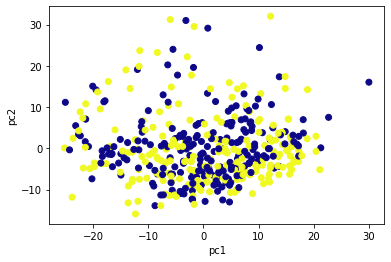

bert-large-cased


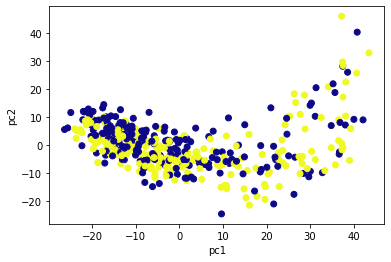

distilbert-base-cased


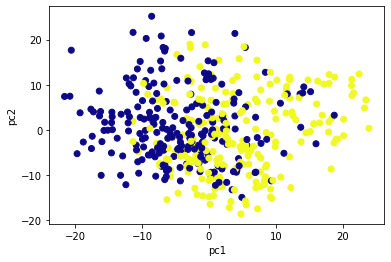

roberta-base


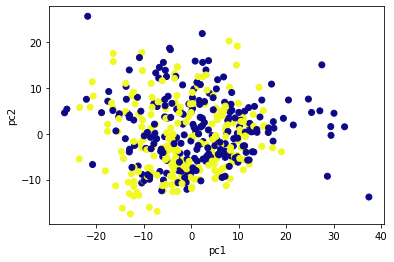

roberta-large


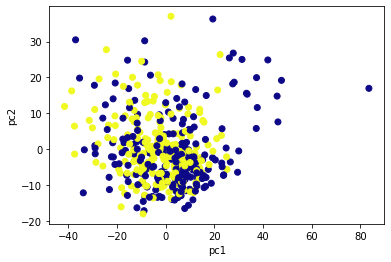

distilroberta-base


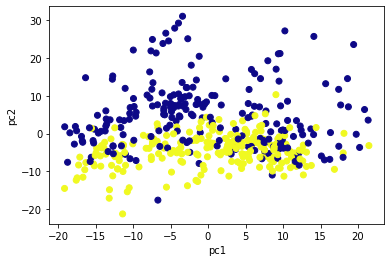

In [9]:
for key, x in pca_dict.items():
    print(key)
    plt.scatter(x[:,0],x[:,1],c=df.YN_INNOVATION,cmap='plasma')
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.show()

bert-base-cased


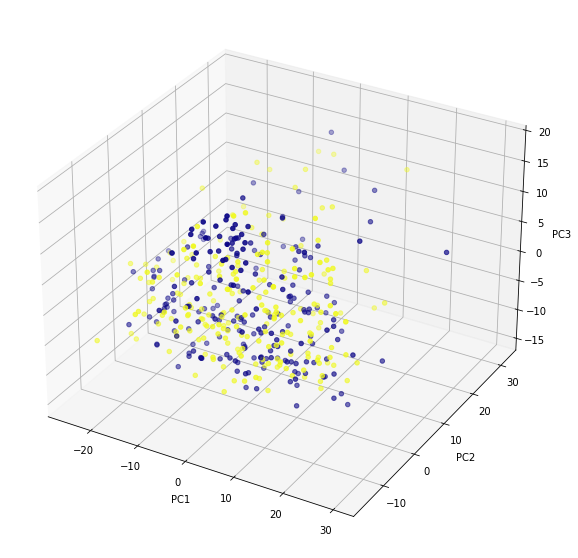

bert-large-cased


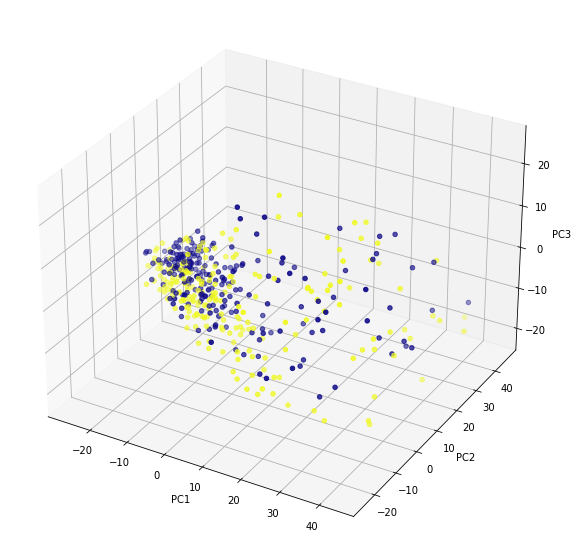

distilbert-base-cased


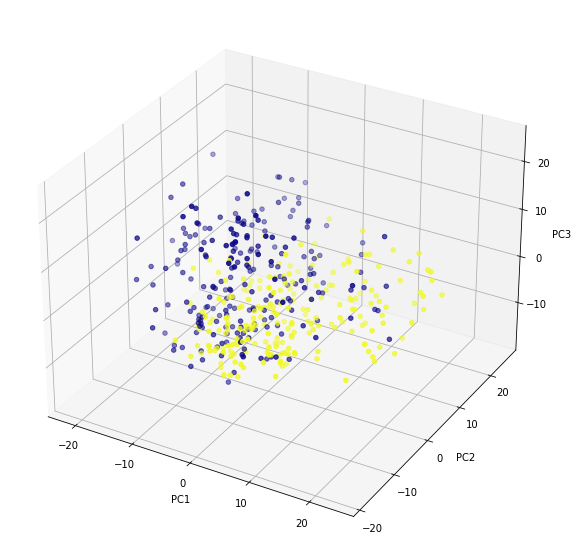

roberta-base


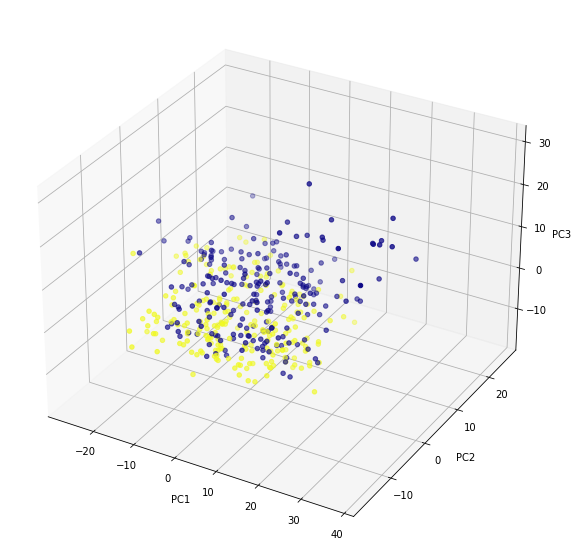

roberta-large


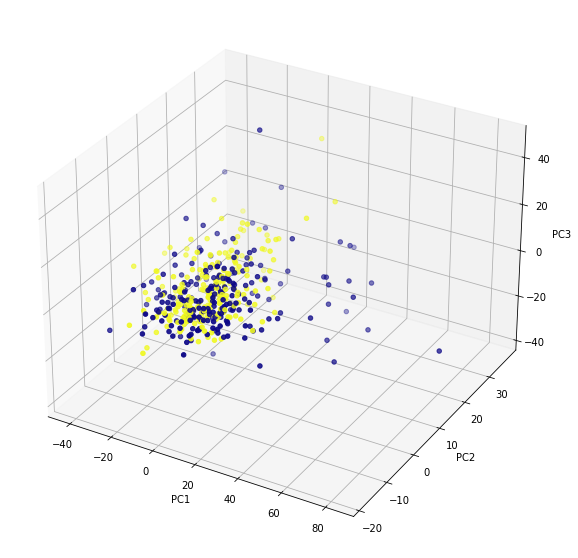

distilroberta-base


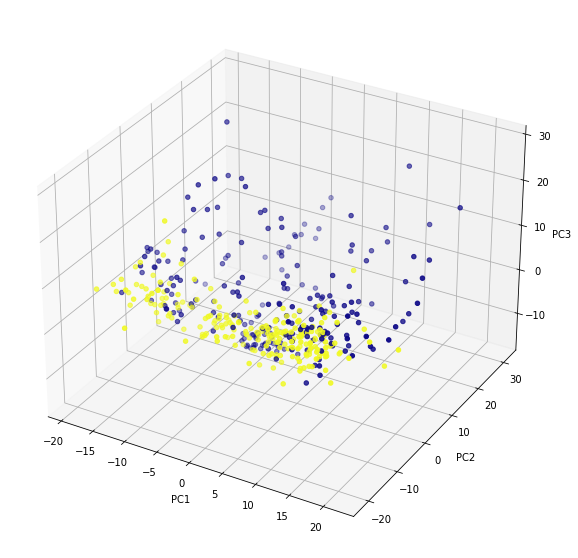

In [20]:
for key, x in pca_dict.items():
    print(key)

    fig = plt.figure(figsize=(10,10))
  
    # choose projection 3d for creating a 3d graph
    axis = fig.add_subplot(111, projection='3d')
  
    # x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3

    axis.scatter(x[:,0],x[:,1],x[:,2], c=df.YN_INNOVATION,cmap='plasma')

    axis.set_xlabel("PC1", fontsize=10)

    axis.set_ylabel("PC2", fontsize=10)

    axis.set_zlabel("PC3", fontsize=10)
    plt.show()

In [10]:
## Splitting th data into train and test sets of features and target
train_features_dict = {}
test_features_dict = {}
train_labels_dict = {}
test_labels_dict = {}

for weights, features in features_dict.items():
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 65432)
    train_features_dict.update({weights:train_features})
    test_features_dict.update({weights:test_features})
    train_labels_dict.update({weights:train_labels})
    test_labels_dict.update({weights:test_labels})

In [11]:
test_labels_predict_dict = {}
test_labels_predict_proba_dict = {}
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
for key in features_dict.keys():
    for kernel in kernel_list:
        clf = make_pipeline(StandardScaler(), svm.SVC(kernel = kernel, probability=True))
        clf.fit(train_features_dict[key],train_labels_dict[key])
        predicted_y = clf.predict(test_features_dict[key])
        pred_prob = clf.predict_proba(test_features_dict[key])[:, 1]
        test_labels_predict_dict.update({key+"_"+kernel+"-kernel":predicted_y})
        test_labels_predict_proba_dict.update({key+"_"+kernel+"-kernel":pred_prob})


========= bert-base-cased_linear-kernel model ==========

Accuracy of the of the bert-base-cased_linear-kernel model is 78.38%.
Precision rate of the bert-base-cased_linear-kernel model is 80.0%.
Recall rate of the bert-base-cased_linear-kernel model is 77.19%.
F-1 score of the bert-base-cased_linear-kernel model is 78.57%.

The confusion matrix for the bert-base-cased_linear-kernel model is:


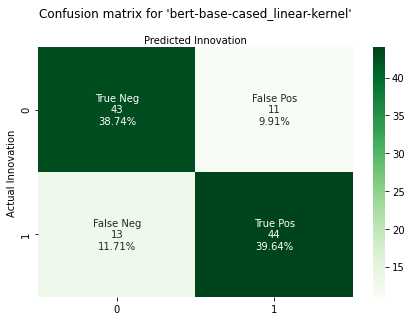

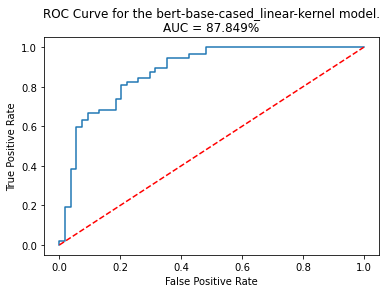


========= bert-base-cased_poly-kernel model ==========

Accuracy of the of the bert-base-cased_poly-kernel model is 67.57%.
Precision rate of the bert-base-cased_poly-kernel model is 64.0%.
Recall rate of the bert-base-cased_poly-kernel model is 84.21%.
F-1 score of the bert-base-cased_poly-kernel model is 72.73%.

The confusion matrix for the bert-base-cased_poly-kernel model is:


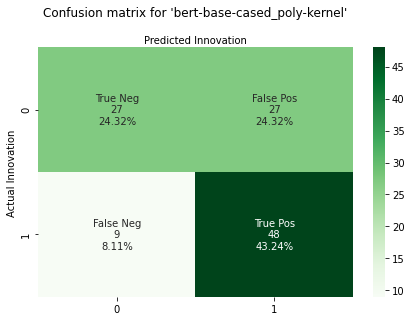

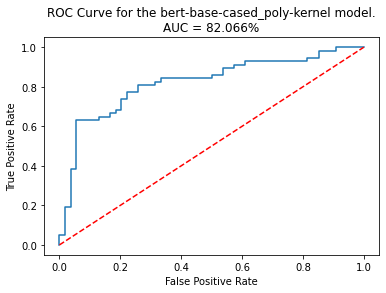


========= bert-base-cased_rbf-kernel model ==========

Accuracy of the of the bert-base-cased_rbf-kernel model is 81.08%.
Precision rate of the bert-base-cased_rbf-kernel model is 80.0%.
Recall rate of the bert-base-cased_rbf-kernel model is 84.21%.
F-1 score of the bert-base-cased_rbf-kernel model is 82.05%.

The confusion matrix for the bert-base-cased_rbf-kernel model is:


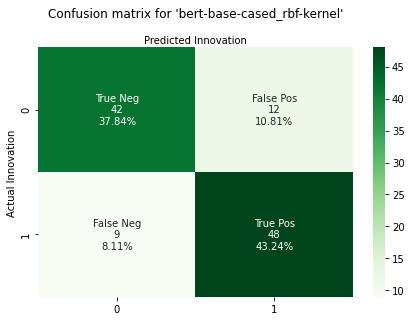

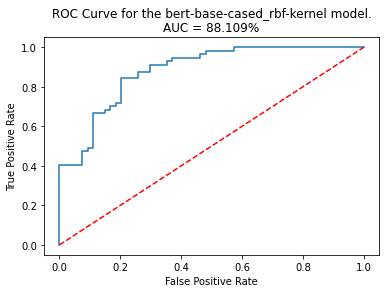


========= bert-base-cased_sigmoid-kernel model ==========

Accuracy of the of the bert-base-cased_sigmoid-kernel model is 80.18%.
Precision rate of the bert-base-cased_sigmoid-kernel model is 76.92%.
Recall rate of the bert-base-cased_sigmoid-kernel model is 87.72%.
F-1 score of the bert-base-cased_sigmoid-kernel model is 81.97%.

The confusion matrix for the bert-base-cased_sigmoid-kernel model is:


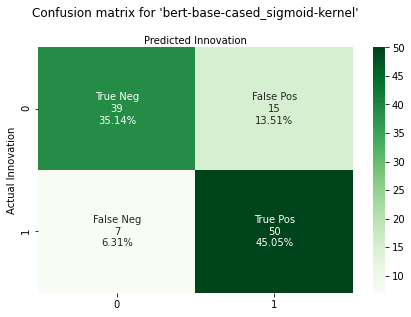

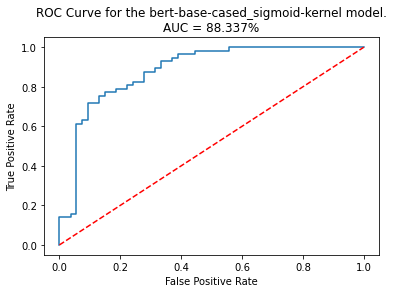


========= bert-large-cased_linear-kernel model ==========

Accuracy of the of the bert-large-cased_linear-kernel model is 72.97%.
Precision rate of the bert-large-cased_linear-kernel model is 72.88%.
Recall rate of the bert-large-cased_linear-kernel model is 75.44%.
F-1 score of the bert-large-cased_linear-kernel model is 74.14%.

The confusion matrix for the bert-large-cased_linear-kernel model is:


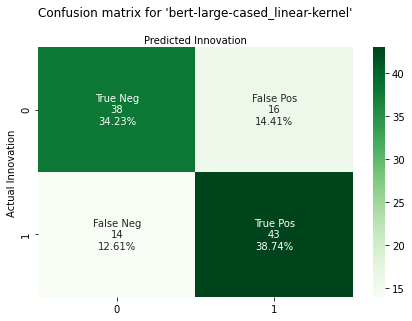

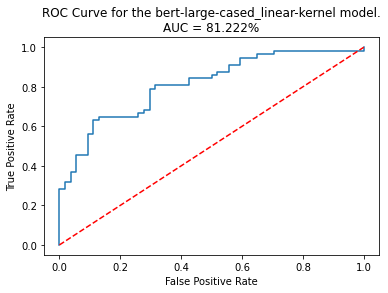


========= bert-large-cased_poly-kernel model ==========

Accuracy of the of the bert-large-cased_poly-kernel model is 59.46%.
Precision rate of the bert-large-cased_poly-kernel model is 77.27%.
Recall rate of the bert-large-cased_poly-kernel model is 29.82%.
F-1 score of the bert-large-cased_poly-kernel model is 43.04%.

The confusion matrix for the bert-large-cased_poly-kernel model is:


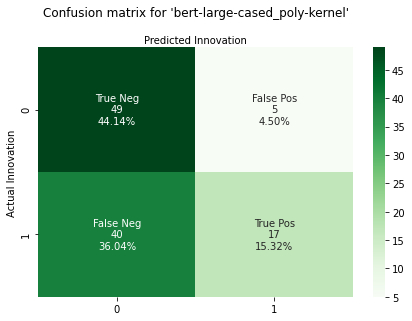

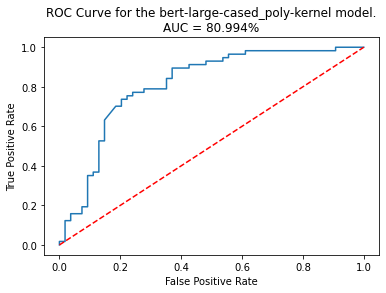


========= bert-large-cased_rbf-kernel model ==========

Accuracy of the of the bert-large-cased_rbf-kernel model is 78.38%.
Precision rate of the bert-large-cased_rbf-kernel model is 75.38%.
Recall rate of the bert-large-cased_rbf-kernel model is 85.96%.
F-1 score of the bert-large-cased_rbf-kernel model is 80.33%.

The confusion matrix for the bert-large-cased_rbf-kernel model is:


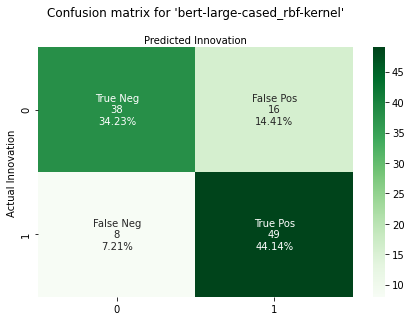

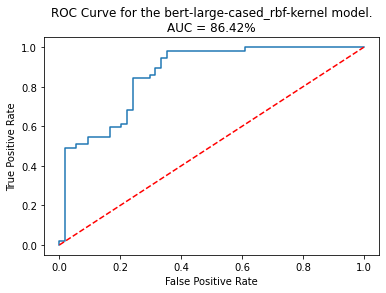


========= bert-large-cased_sigmoid-kernel model ==========

Accuracy of the of the bert-large-cased_sigmoid-kernel model is 77.48%.
Precision rate of the bert-large-cased_sigmoid-kernel model is 78.57%.
Recall rate of the bert-large-cased_sigmoid-kernel model is 77.19%.
F-1 score of the bert-large-cased_sigmoid-kernel model is 77.88%.

The confusion matrix for the bert-large-cased_sigmoid-kernel model is:


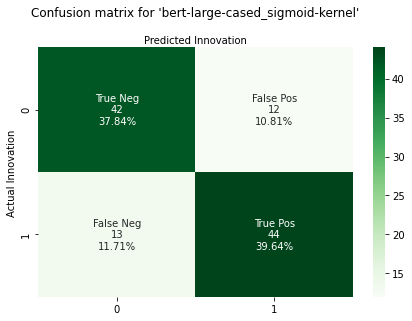

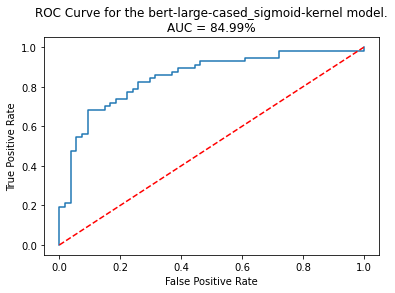


========= distilbert-base-cased_linear-kernel model ==========

Accuracy of the of the distilbert-base-cased_linear-kernel model is 76.58%.
Precision rate of the distilbert-base-cased_linear-kernel model is 77.19%.
Recall rate of the distilbert-base-cased_linear-kernel model is 77.19%.
F-1 score of the distilbert-base-cased_linear-kernel model is 77.19%.

The confusion matrix for the distilbert-base-cased_linear-kernel model is:


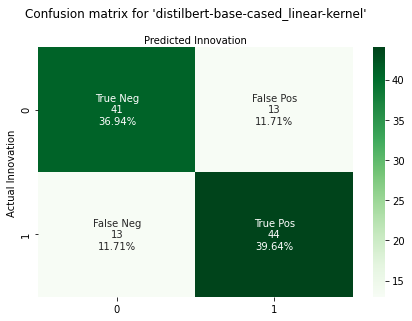

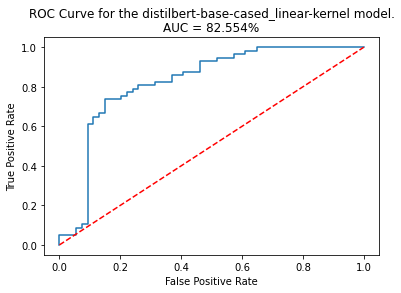


========= distilbert-base-cased_poly-kernel model ==========

Accuracy of the of the distilbert-base-cased_poly-kernel model is 68.47%.
Precision rate of the distilbert-base-cased_poly-kernel model is 61.96%.
Recall rate of the distilbert-base-cased_poly-kernel model is 100.0%.
F-1 score of the distilbert-base-cased_poly-kernel model is 76.51%.

The confusion matrix for the distilbert-base-cased_poly-kernel model is:


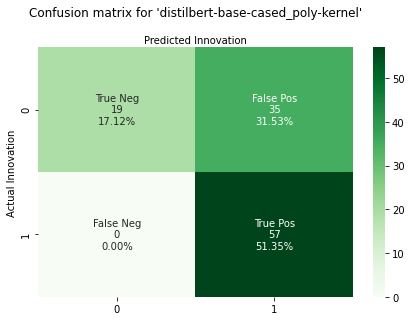

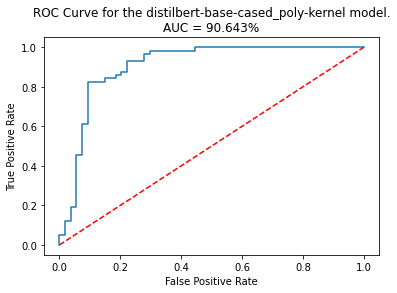


========= distilbert-base-cased_rbf-kernel model ==========

Accuracy of the of the distilbert-base-cased_rbf-kernel model is 83.78%.
Precision rate of the distilbert-base-cased_rbf-kernel model is 78.26%.
Recall rate of the distilbert-base-cased_rbf-kernel model is 94.74%.
F-1 score of the distilbert-base-cased_rbf-kernel model is 85.71%.

The confusion matrix for the distilbert-base-cased_rbf-kernel model is:


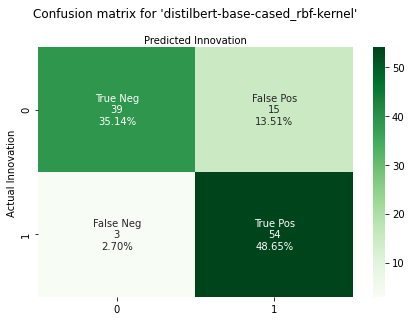

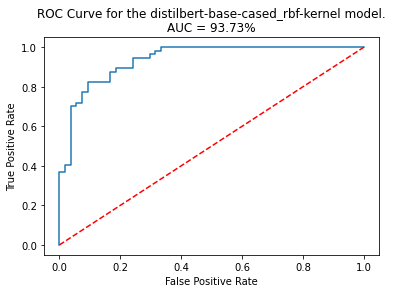


========= distilbert-base-cased_sigmoid-kernel model ==========

Accuracy of the of the distilbert-base-cased_sigmoid-kernel model is 83.78%.
Precision rate of the distilbert-base-cased_sigmoid-kernel model is 79.1%.
Recall rate of the distilbert-base-cased_sigmoid-kernel model is 92.98%.
F-1 score of the distilbert-base-cased_sigmoid-kernel model is 85.48%.

The confusion matrix for the distilbert-base-cased_sigmoid-kernel model is:


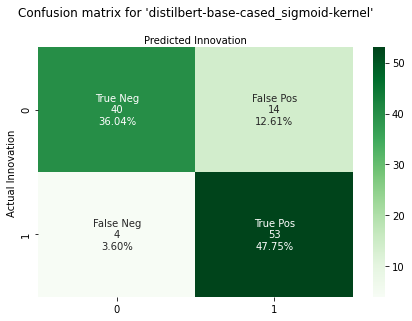

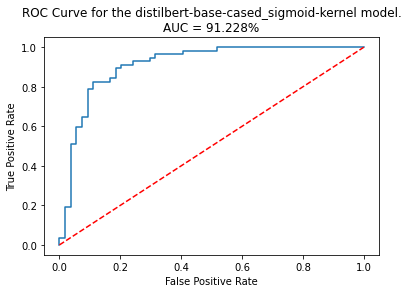


========= roberta-base_linear-kernel model ==========

Accuracy of the of the roberta-base_linear-kernel model is 78.38%.
Precision rate of the roberta-base_linear-kernel model is 77.97%.
Recall rate of the roberta-base_linear-kernel model is 80.7%.
F-1 score of the roberta-base_linear-kernel model is 79.31%.

The confusion matrix for the roberta-base_linear-kernel model is:


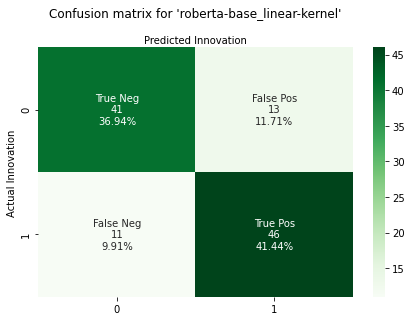

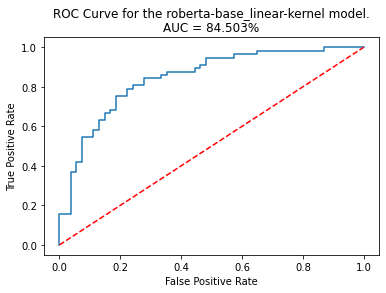


========= roberta-base_poly-kernel model ==========

Accuracy of the of the roberta-base_poly-kernel model is 71.17%.
Precision rate of the roberta-base_poly-kernel model is 64.37%.
Recall rate of the roberta-base_poly-kernel model is 98.25%.
F-1 score of the roberta-base_poly-kernel model is 77.78%.

The confusion matrix for the roberta-base_poly-kernel model is:


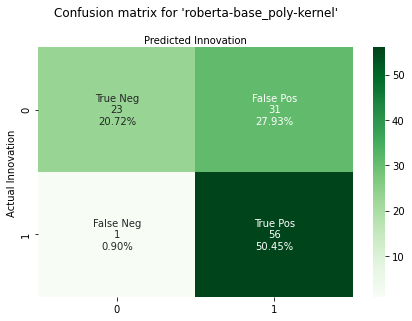

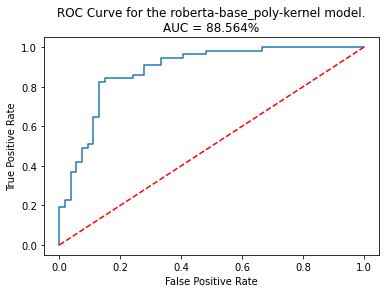


========= roberta-base_rbf-kernel model ==========

Accuracy of the of the roberta-base_rbf-kernel model is 81.98%.
Precision rate of the roberta-base_rbf-kernel model is 78.46%.
Recall rate of the roberta-base_rbf-kernel model is 89.47%.
F-1 score of the roberta-base_rbf-kernel model is 83.61%.

The confusion matrix for the roberta-base_rbf-kernel model is:


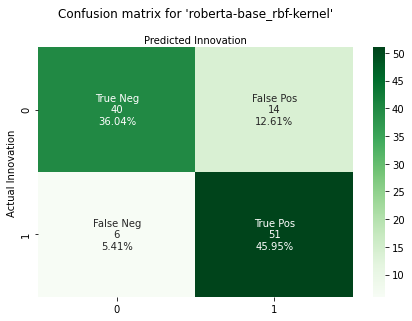

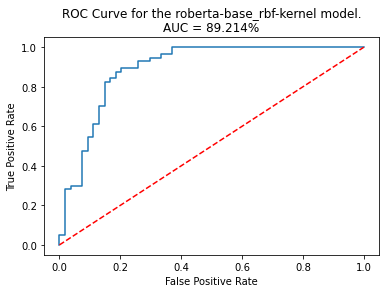


========= roberta-base_sigmoid-kernel model ==========

Accuracy of the of the roberta-base_sigmoid-kernel model is 82.88%.
Precision rate of the roberta-base_sigmoid-kernel model is 79.69%.
Recall rate of the roberta-base_sigmoid-kernel model is 89.47%.
F-1 score of the roberta-base_sigmoid-kernel model is 84.3%.

The confusion matrix for the roberta-base_sigmoid-kernel model is:


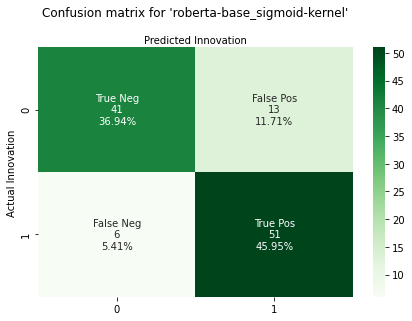

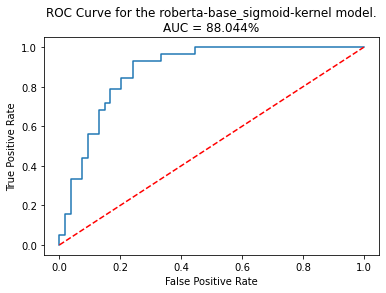


========= roberta-large_linear-kernel model ==========

Accuracy of the of the roberta-large_linear-kernel model is 81.08%.
Precision rate of the roberta-large_linear-kernel model is 81.03%.
Recall rate of the roberta-large_linear-kernel model is 82.46%.
F-1 score of the roberta-large_linear-kernel model is 81.74%.

The confusion matrix for the roberta-large_linear-kernel model is:


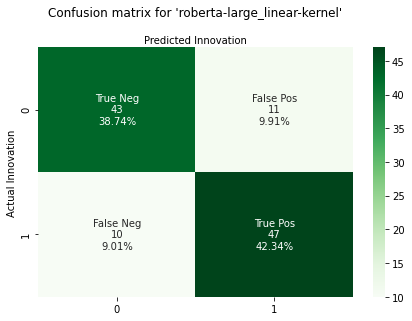

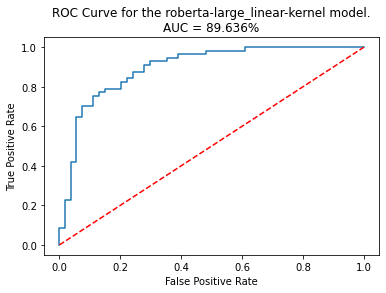


========= roberta-large_poly-kernel model ==========

Accuracy of the of the roberta-large_poly-kernel model is 66.67%.
Precision rate of the roberta-large_poly-kernel model is 60.64%.
Recall rate of the roberta-large_poly-kernel model is 100.0%.
F-1 score of the roberta-large_poly-kernel model is 75.5%.

The confusion matrix for the roberta-large_poly-kernel model is:


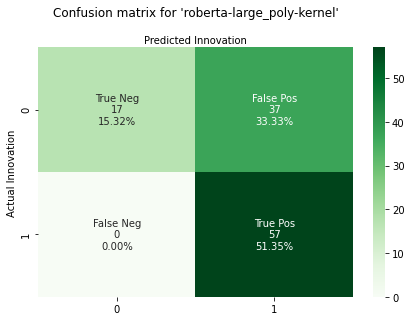

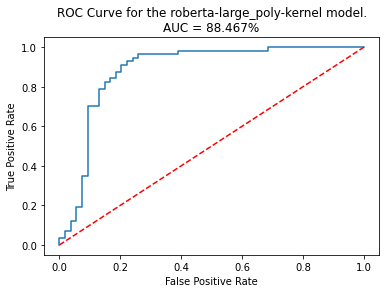


========= roberta-large_rbf-kernel model ==========

Accuracy of the of the roberta-large_rbf-kernel model is 81.98%.
Precision rate of the roberta-large_rbf-kernel model is 78.46%.
Recall rate of the roberta-large_rbf-kernel model is 89.47%.
F-1 score of the roberta-large_rbf-kernel model is 83.61%.

The confusion matrix for the roberta-large_rbf-kernel model is:


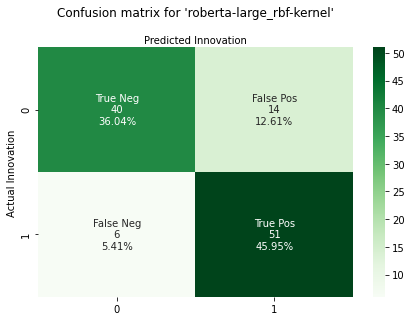

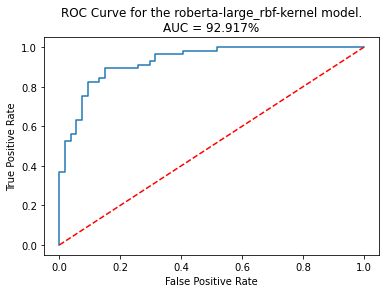


========= roberta-large_sigmoid-kernel model ==========

Accuracy of the of the roberta-large_sigmoid-kernel model is 77.48%.
Precision rate of the roberta-large_sigmoid-kernel model is 74.24%.
Recall rate of the roberta-large_sigmoid-kernel model is 85.96%.
F-1 score of the roberta-large_sigmoid-kernel model is 79.67%.

The confusion matrix for the roberta-large_sigmoid-kernel model is:


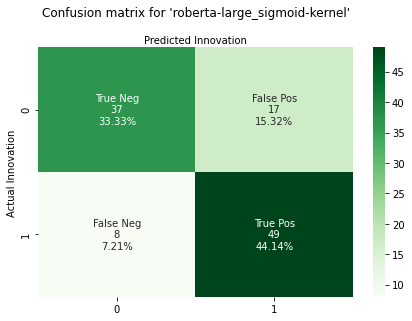

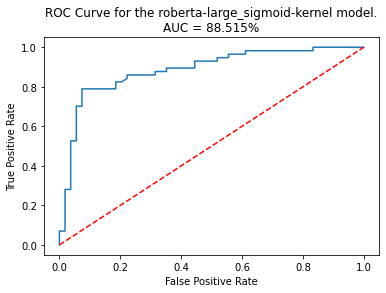


========= distilroberta-base_linear-kernel model ==========

Accuracy of the of the distilroberta-base_linear-kernel model is 77.48%.
Precision rate of the distilroberta-base_linear-kernel model is 74.24%.
Recall rate of the distilroberta-base_linear-kernel model is 85.96%.
F-1 score of the distilroberta-base_linear-kernel model is 79.67%.

The confusion matrix for the distilroberta-base_linear-kernel model is:


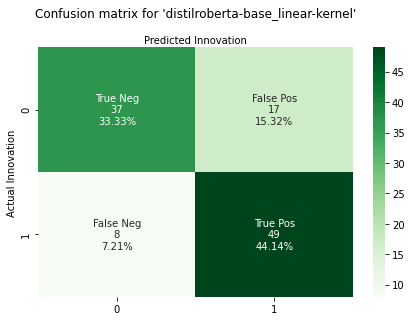

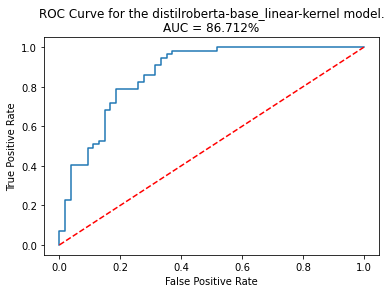


========= distilroberta-base_poly-kernel model ==========

Accuracy of the of the distilroberta-base_poly-kernel model is 74.77%.
Precision rate of the distilroberta-base_poly-kernel model is 67.06%.
Recall rate of the distilroberta-base_poly-kernel model is 100.0%.
F-1 score of the distilroberta-base_poly-kernel model is 80.28%.

The confusion matrix for the distilroberta-base_poly-kernel model is:


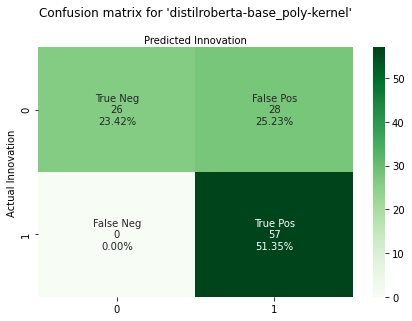

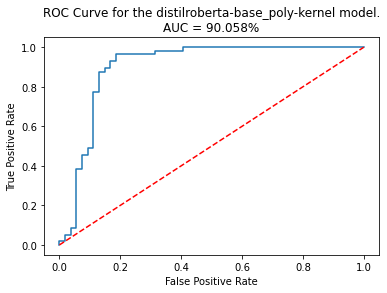


========= distilroberta-base_rbf-kernel model ==========

Accuracy of the of the distilroberta-base_rbf-kernel model is 84.68%.
Precision rate of the distilroberta-base_rbf-kernel model is 79.41%.
Recall rate of the distilroberta-base_rbf-kernel model is 94.74%.
F-1 score of the distilroberta-base_rbf-kernel model is 86.4%.

The confusion matrix for the distilroberta-base_rbf-kernel model is:


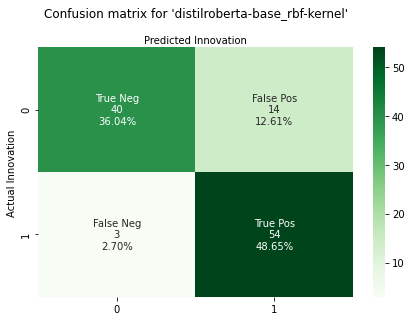

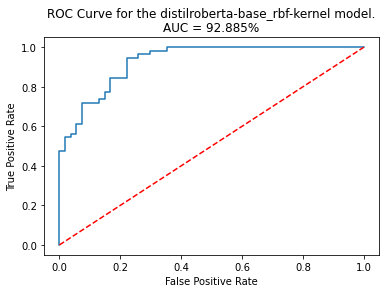


========= distilroberta-base_sigmoid-kernel model ==========

Accuracy of the of the distilroberta-base_sigmoid-kernel model is 86.49%.
Precision rate of the distilroberta-base_sigmoid-kernel model is 81.82%.
Recall rate of the distilroberta-base_sigmoid-kernel model is 94.74%.
F-1 score of the distilroberta-base_sigmoid-kernel model is 87.8%.

The confusion matrix for the distilroberta-base_sigmoid-kernel model is:


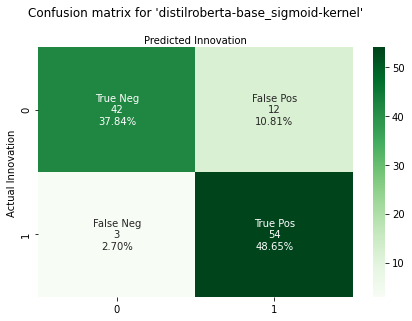

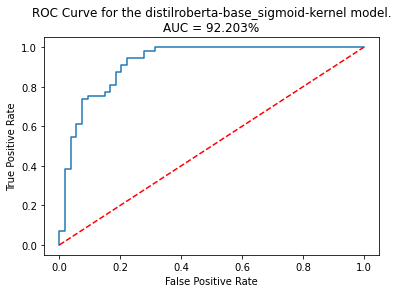

In [12]:
for key in test_labels_predict_dict.keys():
    print("\n=========",key, "model ==========\n")
    key0 = str.split(key, "_")[0]
    
    # Metrics
    accuracy = metrics.accuracy_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    precision=metrics.precision_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    recall=metrics.recall_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    f1_score = metrics.f1_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    
    print("Accuracy of the of the", key ,"model is {}%.".format(round((accuracy*100),2)))
    print("Precision rate of the", key, "model is {}%.".format(round((precision*100),2)))
    print("Recall rate of the", key, "model is {}%.".format(round((recall*100),2)))
    print("F-1 score of the", key, "model is {}%.".format(round((f1_score*100),2)))
    
    # Confusion Matrix
    print("\nThe confusion matrix for the", key,"model is:")
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()/np.sum(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]), annot=labels, fmt='', cmap='Greens')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix for %r'%key, y=1.1)
    plt.ylabel('Actual Innovation')
    plt.xlabel('Predicted Innovation')
    plt.show()
    
    
    # ROC Graph
    fpr, tpr, thresholds = roc_curve(test_labels_dict[key0], test_labels_predict_proba_dict[key])
    auc = roc_auc_score(test_labels_dict[key0], test_labels_predict_proba_dict[key])

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', color="red")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for the "+key+" model.\nAUC = "+str(round(auc*100, 3))+"%")
    plt.show()

In [13]:
metrics_dict = {}

for key in test_labels_predict_dict.keys():
    key0 = str.split(key, "_")[0]
    accuracy = metrics.accuracy_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    precision=metrics.precision_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    recall=metrics.recall_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    f1_score = metrics.f1_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    auc = roc_auc_score(test_labels_dict[key0], test_labels_predict_proba_dict[key])
    
    true_neg = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[0][0]
    false_pos = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[0][1]
    false_neg = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[1][0]
    true_pos = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[1][1]
    
    metrics_dict.update({key:{"accuracy": accuracy, 
                              "precision": precision, 
                              "recall": recall, 
                              "f1_score": f1_score, 
                              "auc": auc,
                              "true_positive": true_pos,
                              "true_negative": true_neg, 
                              "false_positive": false_pos,
                              "false_negative": false_neg}})

In [17]:
pd.DataFrame(metrics_dict).T

,accuracy,precision,recall,f1_score,auc,true_positive,true_negative,false_positive,false_negative
bert-base-cased_linear-kernel,0.783784,0.800000,0.771930,0.785714,0.878493,44.0,43.0,11.0,13.0
bert-base-cased_poly-kernel,0.675676,0.640000,0.842105,0.727273,0.820663,48.0,27.0,27.0,9.0
bert-base-cased_rbf-kernel,0.810811,0.800000,0.842105,0.820513,0.881092,48.0,42.0,12.0,9.0
bert-base-cased_sigmoid-kernel,0.801802,0.769231,0.877193,0.819672,0.883366,50.0,39.0,15.0,7.0
bert-large-cased_linear-kernel,0.729730,0.728814,0.754386,0.741379,0.812216,43.0,38.0,16.0,14.0
bert-large-cased_poly-kernel,0.594595,0.772727,0.298246,0.430380,0.809942,17.0,49.0,5.0,40.0
bert-large-cased_rbf-kernel,0.783784,0.753846,0.859649,0.803279,0.864198,49.0,38.0,16.0,8.0
bert-large-cased_sigmoid-kernel,0.774775,0.785714,0.771930,0.778761,0.849903,44.0,42.0,12.0,13.0
distilbert-base-cased_linear-kernel,0.765766,0.771930,0.771930,0.771930,0.825536,44.0,41.0,13.0,13.0
distilbert-base-cased_poly-kernel,0.684685,0.619565,1.000000,0.765101,0.906433,57.0,19.0,35.0,0.0


In [ ]:
## Saving SVM Model metrics to DataFrame
pd.DataFrame(metrics_dict).T.to_csv("svm_model_metrics.csv")

In [ ]:
## Saving a dataframe of the data with predicted labels from models
pred_df = pd.DataFrame(test_labels_predict_dict, index = test_labels_dict['bert-base-cased'].index)
pd.concat([df_save.iloc[test_labels_dict['bert-base-cased'].index,], pred_df], axis=1).to_csv("svm_test_data_comparison.csv")